<div align="left">
<img align="left" src="../misc/site-logo.png" >
<div> <b> 2018 Data Science Bowl </b> </div>
<div> Pedro D. Marrero Fernandez</div>
<div> https://www.kaggle.com/c/data-science-bowl-2018/discussion/47770 </div>
<div> :), :(, :/</div>
</div>   

In [1]:
import os
import sys

import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
import time

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import scipy.misc
import cv2

from pytvision.datasets.syntheticdata import SyntethicCircleDataset
from pytvision.transforms import transforms as mtrans
from pytvision import visualization as view

sys.path.append('../')
from torchlib.segneuralnet import SegmentationNeuralNet
from torchlib import postprocessing as posp
from torchlib.datasets import imageutl as imutl


# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [2]:
def imageshowlist(image_in, image_out ):    
    plt.figure( figsize=(16,16))
    plt.subplot(121)
    plt.imshow( image_in )
    plt.title('Image input')
    plt.axis('off')
    plt.subplot(122)
    plt.imshow( image_out )
    plt.title('Image output')
    plt.axis('off')
    plt.show()

def imageshow( image, title='image'):
    plt.figure( figsize=(8,8))
    plt.imshow( image )
    plt.axis('off')
    plt.show()

In [3]:
!ls ../netruns/

exp_datasciencebowl_unet_wmce_adam_databoewlex_001


In [6]:
# configuration
PATHDATASET = os.path.expanduser( '~/.datasets/datasciencebowl'  )
NAMEDATASET = 'databoewl'
METADATA = 'stage1_train_labels.csv'
PATHPROJECT='../netruns/'
NAMEPROJECT='exp_datasciencebowl_unet_wmce_adam_databoewlex_001'
NAMEMODEL = 'model_best.pth.tar'
RLNAME = 'test_masks.csv'
NUMITER = 5

PATHNAMEDATASET = os.path.join(PATHDATASET, NAMEDATASET);
PATHNAMEDMETADATA = os.path.join(PATHDATASET, NAMEDATASET, METADATA)
PATHNAMEMODEL = os.path.join(PATHPROJECT, NAMEPROJECT, 'models',NAMEMODEL)

print(PATHNAMEDATASET)
print(PATHNAMEDMETADATA)
print(PATHNAMEMODEL)



/home/fernandez/.datasets/datasciencebowl/databoewl
/home/fernandez/.datasets/datasciencebowl/databoewl/stage1_train_labels.csv
../netruns/exp_datasciencebowl_unet_wmce_adam_databoewlex_001/models/model_best.pth.tar


In [7]:
base_folder = PATHNAMEDATASET
sub_folder =  imutl.testfilefinal
folders_image='images'

dataloader = imutl.dsxbImageProvide.create(
    base_folder, 
    sub_folder, 
    folders_image, 
    )

print(len(dataloader))
print(':)!!!')


3019
:)!!!


In [8]:
project = PATHPROJECT
name = NAMEPROJECT
pathmodel = PATHNAMEMODEL
no_cuda=False
parallel=False
seed=1
gpu=0

print('||> load model ...')
start = time.time()
network = SegmentationNeuralNet( patchproject=project, nameproject=name, no_cuda=no_cuda, parallel=parallel, seed=seed, gpu=gpu )
if network.load( pathmodel ) is not True:
    assert(False)
t = time.time() - start
print('||> load model time: {}sec'.format(t) )



||> load model ...
=> loading checkpoint '../netruns/exp_datasciencebowl_unet_wmce_adam_databoewlex_001/models/model_best.pth.tar'
=> loaded checkpoint for unet arch!
||> load model time: 4.391222238540649sec


6 00b4b9c026cfc91af21691503bad67081fc02d5c77b3cd27200d02dca6966b83


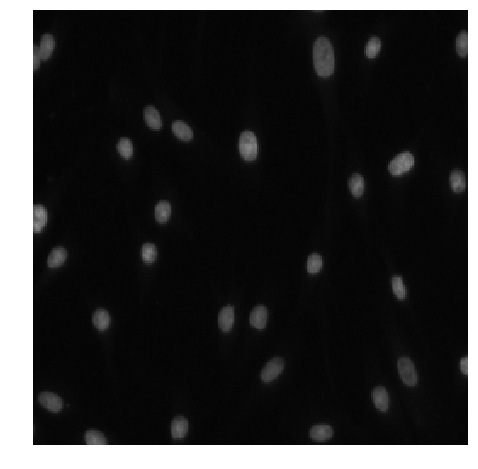

In [71]:
i=6 #49 #24 #32 #20
image = dataloader[ i ]
print(i, dataloader.getid() )

imageshow(image)


(256, 256, 3)
(256, 256, 3)
DONE!!


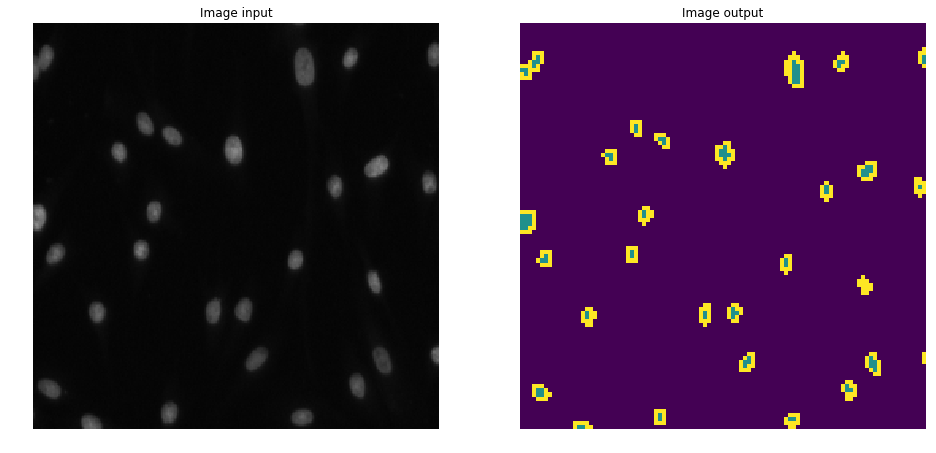

In [75]:
from pytvision.transforms.aumentation import  ObjectImageAndMaskTransform, ObjectImageTransform

imsize=100
transf = transforms.Compose([
    mtrans.ToResize( (500,500), resize_mode='crop', padding_mode=cv2.BORDER_REFLECT_101 ),
    #mtrans.RandomCrop( (255,255), limit=50, padding_mode=cv2.BORDER_REFLECT_101  ),    
    #mtrans.RandomScale(factor=0.2, padding_mode=cv2.BORDER_REFLECT_101 ),
    #mtrans.RandomGeometricalTransform( angle=45, translation=0.2, warp=0.02, padding_mode=cv2.BORDER_REFLECT_101),    
    mtrans.ToResizeUNetFoV(imsize, cv2.BORDER_REFLECT_101),
    mtrans.ToTensor(),
    mtrans.ToNormalization(),
    ])

# obj = ObjectImageAndMaskTransform( image, label.max(2)  )
obj = ObjectImageTransform( image )
obj = transf(obj)

# img, lab = obj.to_value()
img = obj.to_value()
score = network( img.unsqueeze(0) )
predition = np.argmax(score, axis=2).astype('uint8') 

score = cv2.resize( score, (image.shape[0], image.shape[1]) ) #<<===== error output size 

print(score.shape)
print(image.shape)

print('DONE!!')
imageshowlist(image, predition)


(256, 256, 27)


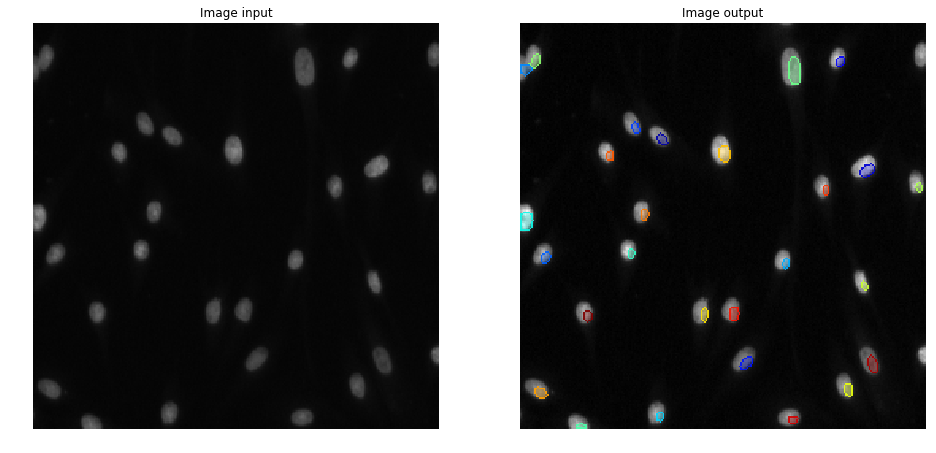

In [82]:
from pytvision import utils


# score_prob = utils.sigmoid(score)
labels_est = posp.mpostprocess(score)
# labels_est = posp.mpostprocessmax(score)
# labels_est = posp.mpostprocessthresh(score, prob=0.01)

labels_mask_est = posp.decompose( labels_est )
labels_mask_est = np.transpose( labels_mask_est, (1,2,0) )
print(labels_mask_est.shape)


labels_mask_est = labels_mask_est[:,:, np.random.permutation(labels_mask_est.shape[2]) ]
imagecell_est = view.makeimagecell(image, labels_mask_est, alphaback=0.3, alphaedge=0.9)
imageshowlist(image, imagecell_est )

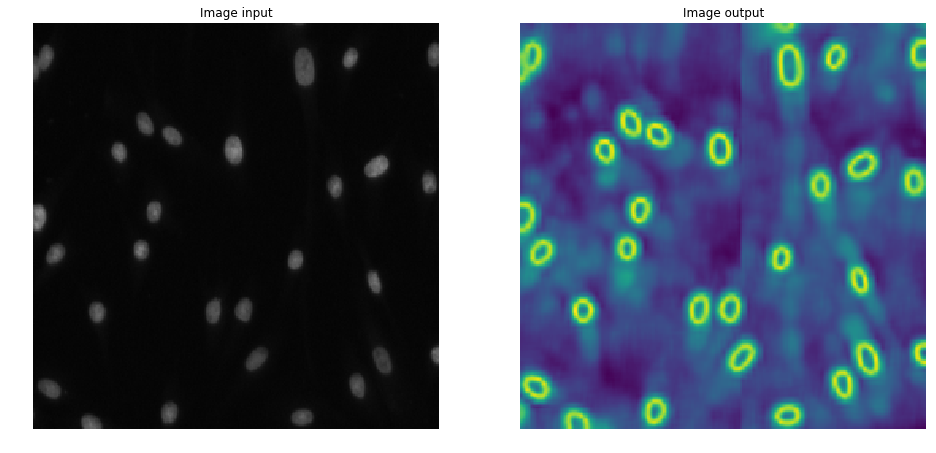

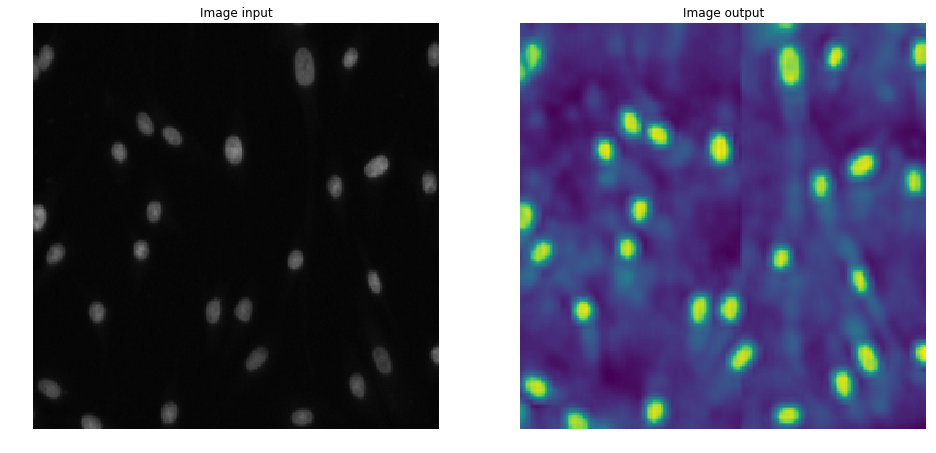

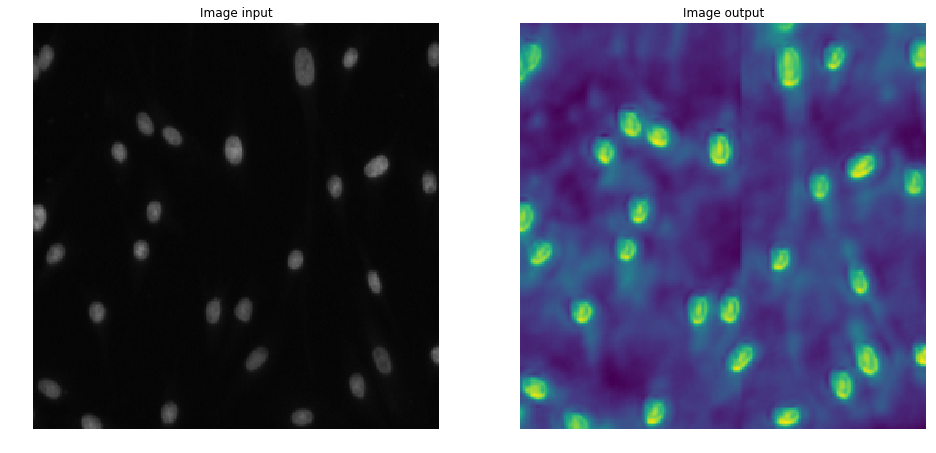

In [13]:
seginfo = nutl.process_data( score[:,:,:2], line_width=1 )

mask_line = seginfo['line_data']>0
image_sh = image.copy()
image_sh[mask_line[:,:,3],:] = [255,0,0];

#imageshowlist(image, image_sh)
imageshowlist(image, score[:,:,2])
imageshowlist(image, score[:,:,1])
imageshowlist(image, score[:,:,0])

(30, 256, 256)
(28, 256, 256)


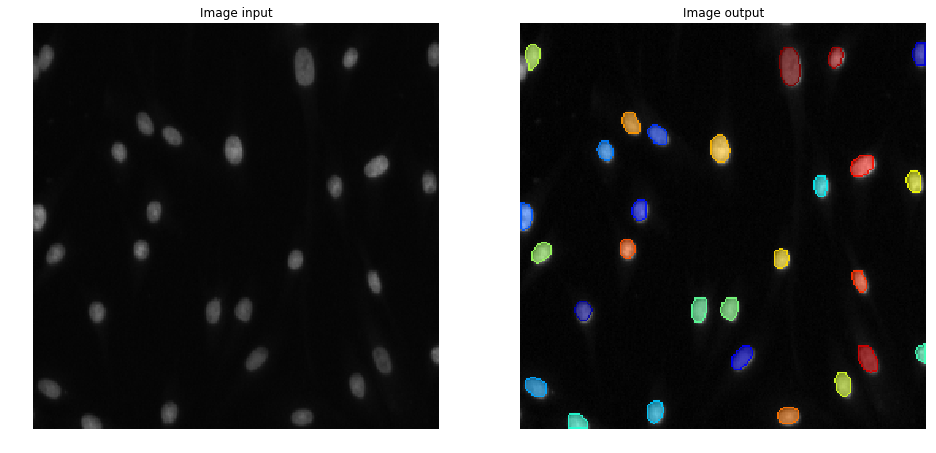

In [14]:
import skimage.morphology as morph
import scipy.ndimage as ndi


def clean_label( masks ):
    
    
    cln_mask = []
    for mask in masks:        
        mask = (mask>128).astype(np.uint8)                
        try:
            _,contours,_ = cv2.findContours(mask, 1, 2) 
            contour = contours[0]
            
            if len(contour) < 5:
                continue
            
            area = cv2.contourArea(contour)
            if area <= 25:  # skip ellipses smaller then 5x5
                continue
            
            epsilon = 0.1*cv2.arcLength(contour,True)
            contour_aprox = cv2.approxPolyDP(contour,epsilon,True)   
            cv2.fillPoly(mask, contour_aprox, 1)  
            
            cln_mask.append(mask)
                        
        except ValueError as e:
            pass
    
    return np.array(cln_mask)



score_prob = nutl.sigmoid(score)
labels_est = posp.mpostprocess(score)
labels_cln = clean_label(labels_est)

print(labels_est.shape)
print(labels_cln.shape)


labels_mask_est = np.transpose( labels_cln, (1,2,0) )

labels_mask_est = labels_mask_est[:,:, np.random.permutation(labels_mask_est.shape[2]) ]
imagecell_est = view.makeimagecell(image, labels_mask_est, alphaback=0.5, alphaedge=0.9)
imageshowlist(image, imagecell_est )


In [ ]:
def create_label( labels ):
    #classe 0 back
    c,m,n = labels.shape
    mlabel = np.zeros_like(labels)
    for i in range(c):
        mlabel[i,:,:] = labels[i,:,:]*(i+1)
        
    mlabel = np.max(mlabel,axis=0)
    return mlabel

labels = create_label(labels_est)
labels = posp.decompose(labels)

labels_mask_est = np.transpose( labels, (1,2,0) )
labels_mask_est = labels_mask_est[:,:, np.random.permutation(labels_mask_est.shape[2]) ]
imagecell_est = view.makeimagecell(image, labels_mask_est, alphaback=0.5, alphaedge=0.9)
imageshowlist(image, imagecell_est )

In [173]:
import scipy.ndimage as ndi

def count(mask):
    labeled, nr_true = ndi.label(mask)
    s = int(np.sum(labeled)>0)
    
    return nr_true,s

score_prob = nutl.sigmoid(score)
labels_est = posp.mpostprocess(score)
labels_est = posp.decompose(labels_est)
total = np.array([ count(x) for x in labels_est ])

nutl.summary(total)

total_t = np.sum(total[:,0])
total_s = np.sum(total[:,1])
print(total_t,total_s, labels_est.shape[0] )



1 1 (82, 2)
82 82 82
